In [1]:
# import libraries
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

In [2]:
# download the weather time series dataset
zip_path = tf.keras.utils.get_file(
    origin=
    'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
# save the csv dataset as a dataframe
df = pd.read_csv(csv_path)

In [4]:
# examine the data
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
# returns a window of time to train the model on
# history_size = size of the past window of information
# target_size = how far into the future does the model need to learn to predict + the label that needs to be predicted
def single_feature_data(dataset, start_index, end_index, history_size,
                    target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size, ) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [6]:
# Train split
TRAIN_PERCENTAGE = 0.7  # 70%
TRAIN_SPLIT = int(TRAIN_PERCENTAGE * len(df))

In [7]:
# Forecast a single feature time series
# Extract the temperature
one_feature_data = df['T (degC)']
one_feature_data.index = df['Date Time']
# Examine the extracted data
one_feature_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1085663d0>],
      dtype=object)

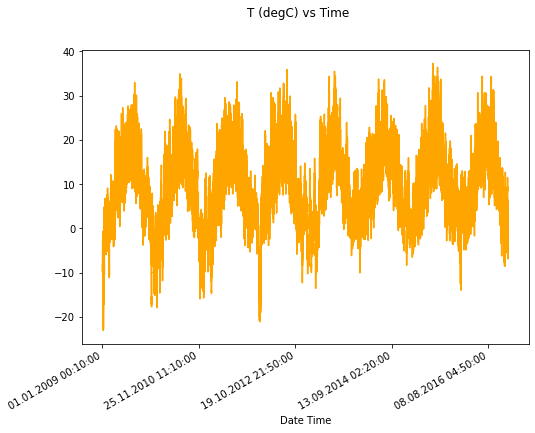

In [8]:
# Observe the data
one_feature_data.plot(subplots=True, color='orange', title='T (degC) vs Time')

In [9]:
# Extract just the temperatures out of the data no date
one_feature_data = one_feature_data.values

In [10]:
# Calculate the data mean and standard deviation
one_feature_data_train_mean = one_feature_data[:TRAIN_SPLIT].mean()
one_feature_data_train_std = one_feature_data[:TRAIN_SPLIT].std()
# Standardize the data
one_feature_data = (one_feature_data -
                    one_feature_data_train_mean) / one_feature_data_train_std

In [11]:
# Create the data for the one feature model
# Model will be given the last 20 recorded temperature observations
# Needs to learn to predict the temperature at the next time step
# Set predict and historical params
ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM = 20
ONE_FEATURE_FUTURE_TARGET_TO_PREDICT = 0

# uni = one feature
# extract training data
# when just doing blind forecasts the TRAIN_SPLIT below will have to be replaced with 
# TRAIN_SPLIT - 7 to do 7 days into the future
x_train_uni, y_train_uni = single_feature_data(
    one_feature_data, 0, TRAIN_SPLIT, ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM,
    ONE_FEATURE_FUTURE_TARGET_TO_PREDICT)
# extract validaion data
x_validation_uni, y_validation_uni = single_feature_data(
    one_feature_data, TRAIN_SPLIT, None,
    ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM,
    ONE_FEATURE_FUTURE_TARGET_TO_PREDICT)

In [12]:
# show the return of single_feature_data
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.97910178]
 [-2.02416646]
 [-2.03572151]
 [-2.01261142]
 [-2.0079894 ]
 [-1.9825683 ]
 [-1.93288159]
 [-1.93288159]
 [-1.96639123]
 [-2.02647747]
 [-2.06460913]
 [-2.07847518]
 [-2.07500867]
 [-2.07269766]
 [-2.05305408]
 [-2.05305408]
 [-2.0576761 ]
 [-2.07038665]
 [-2.07385317]
 [-2.08540821]]

 Target temperature to predict
-2.085408211794277


In [13]:
# create time steps for the plotting
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
# create a graph to show the training data and the predicted value
def show_plot(plot_data, delta, title):
    labels = ['History', 'Actual Future', 'Predicted Future']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future,
                     plot_data[i],
                     marker[i],
                     markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps,
                     plot_data[i].flatten(),
                     marker[i],
                     label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/Python/.pyenv/versions/3.8.0/lib/python3.8/site-packages/matplotlib/pyplot.py'>

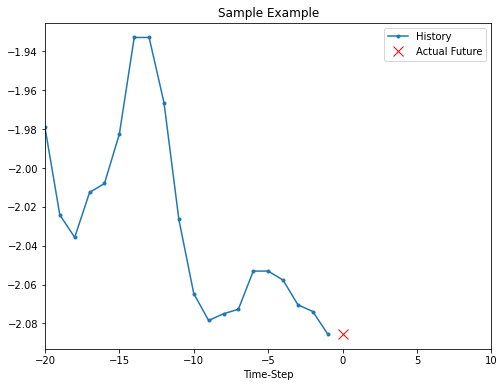

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

# Baseline

In [16]:
# before training the model, set a simple baseline
# given an input the baseline looks at the history 
# and predicts the next point to be the average of the last 20 observations

def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/Python/.pyenv/versions/3.8.0/lib/python3.8/site-packages/matplotlib/pyplot.py'>

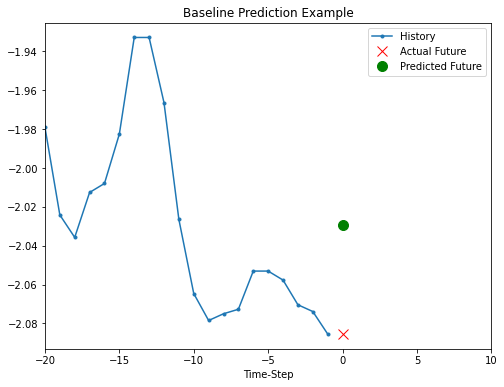

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

# Recurrent neural network

In [18]:
# shuffle, batch and cache the dataset
BATCH_SIZE = int(len(x_train_uni) / 1149)
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices(
    (x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(
    BATCH_SIZE).repeat()

validation_univariate = tf.data.Dataset.from_tensor_slices(
    (x_validation_uni, y_validation_uni))
validation_univariate = validation_univariate.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [19]:
# setup the lstm network
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [20]:
# check the model input and output
for x, y in validation_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [23]:
# EVALUATION_INTERVAL = len(x_train_uni)
EVALUATION_INTERVAL = 1000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation_univariate, validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 8.6552e-04 - val_loss: 6.1795e-04
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 7.4826e-04 - val_loss: 5.4907e-04
Epoch 3/10
1000/1000 [==============================] - 10s 10ms/step - loss: 6.5765e-04 - val_loss: 4.5429e-04
Epoch 4/10
1000/1000 [==============================] - 10s 10ms/step - loss: 5.9068e-04 - val_loss: 4.6872e-04
Epoch 5/10
1000/1000 [==============================] - 10s 10ms/step - loss: 5.5476e-04 - val_loss: 4.7643e-04
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 5.5364e-04 - val_loss: 4.7931e-04
Epoch 7/10
1000/1000 [==============================] - 10s 10ms/step - loss: 5.7663e-04 - val_loss: 5.0680e-04
Epoch 8/10
1000/1000 [==============================] - 9s 9ms/step - loss: 5.4545e-04 - val_loss: 4.8193e-04
Epoch 9/10
1000/1000 [==============================] - 9s 9ms/step - loss: 5.6892e-04 - val_loss: 4.6944e-0

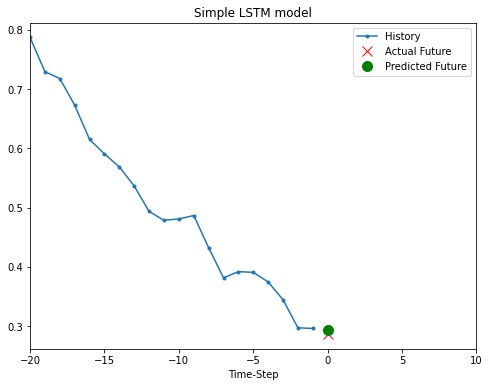

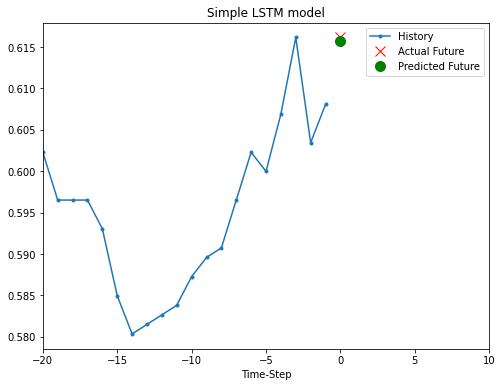

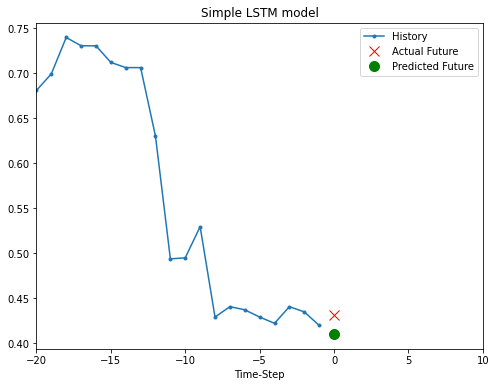

In [24]:
# Predict using the simple lstm model

for x, y in validation_univariate.take(3):
    plot = show_plot(
        [x[0].numpy(), y[0].numpy(),
         simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plt.show()